In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import io
from torchmetrics import PeakSignalNoiseRatio as PSNR, StructuralSimilarityIndexMeasure as SSIM
from piq import LPIPS
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm 
from skimage.metrics import structural_similarity as ssim
import lpips 
from torch.optim.lr_scheduler import LambdaLR
from torchvision.utils import save_image
import random

## Preprocessing

In [2]:
dataset_path1 = '/home/tdiykanba2/codes/RRDB_SE_CHECKPOINTS_color_jitter/augmented_images'
train_path = f'{dataset_path1}/train'
val_path = f'{dataset_path1}/val'
test_path = f'{dataset_path1}/test'

In [3]:
class CleanDataset(Dataset):
    def __init__(self, root_dir, target_transform=None):
        self.root_dir = root_dir
        self.target_transform = target_transform
        self.low_dir = os.path.join(root_dir, "low")
        self.high_dir = os.path.join(root_dir, "high")
        self.image_names = sorted(os.listdir(self.low_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.target_transform:
            low_img = self.target_transform(low_img)
            high_img = self.target_transform(high_img)
            
            
        low_filename = os.path.basename(low_img_path)
        high_filename = os.path.basename(high_img_path)
        
        return low_img, high_img, low_filename, high_filename

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = CleanDataset(
    root_dir=train_path, 
    target_transform = target_transform
)

val_dataset = CleanDataset(
    root_dir=val_path,
    target_transform = target_transform
)

test_dataset = CleanDataset(root_dir=test_path, target_transform = target_transform)

In [4]:
batch_size = 8
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True   # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,         # No need for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,       # Often use batch_size=1 for testing
    shuffle=False,
    num_workers=1
)

In [5]:
def show_true_images(low_batch, high_batch, n=4):

    """
    Shows EXACTLY what's in your dataset with correct color handling.
    Works for both normalized and unnormalized images.
    """

    plt.figure(figsize=(18, 8))

    for i in range(min(n, len(low_batch))):
        # --- Low-light ---
        plt.subplot(2, n, i+1)
        low_img = low_batch[i].permute(1, 2, 0).numpy()

        # Handle normalization if present
        if low_img.min() < 0:  # Likely normalized
            low_img = (low_img * 0.5 + 0.5)  # Reverse imagenet norm

        # Ensure proper image range
        low_img = np.clip(low_img, 0, 1)
        plt.imshow(low_img)
        plt.title(f"Low")
        plt.axis('off')

        # --- Normal-light ---
        plt.subplot(2, n, n+i+1)
        high_img = high_batch[i].permute(1, 2, 0).numpy()

        if high_img.min() < 0:  # Likely normalized
            high_img = (high_img * 0.5 + 0.5)

        high_img = np.clip(high_img, 0, 1)
        plt.imshow(high_img)
        plt.title(f"High")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Low resolution file name: ['136.png', '102.png', '670.png', '594.png', '765.png', '717.png', '121.png', '471.png']
High resolution file name: ['136.png', '102.png', '670.png', '594.png', '765.png', '717.png', '121.png', '471.png']


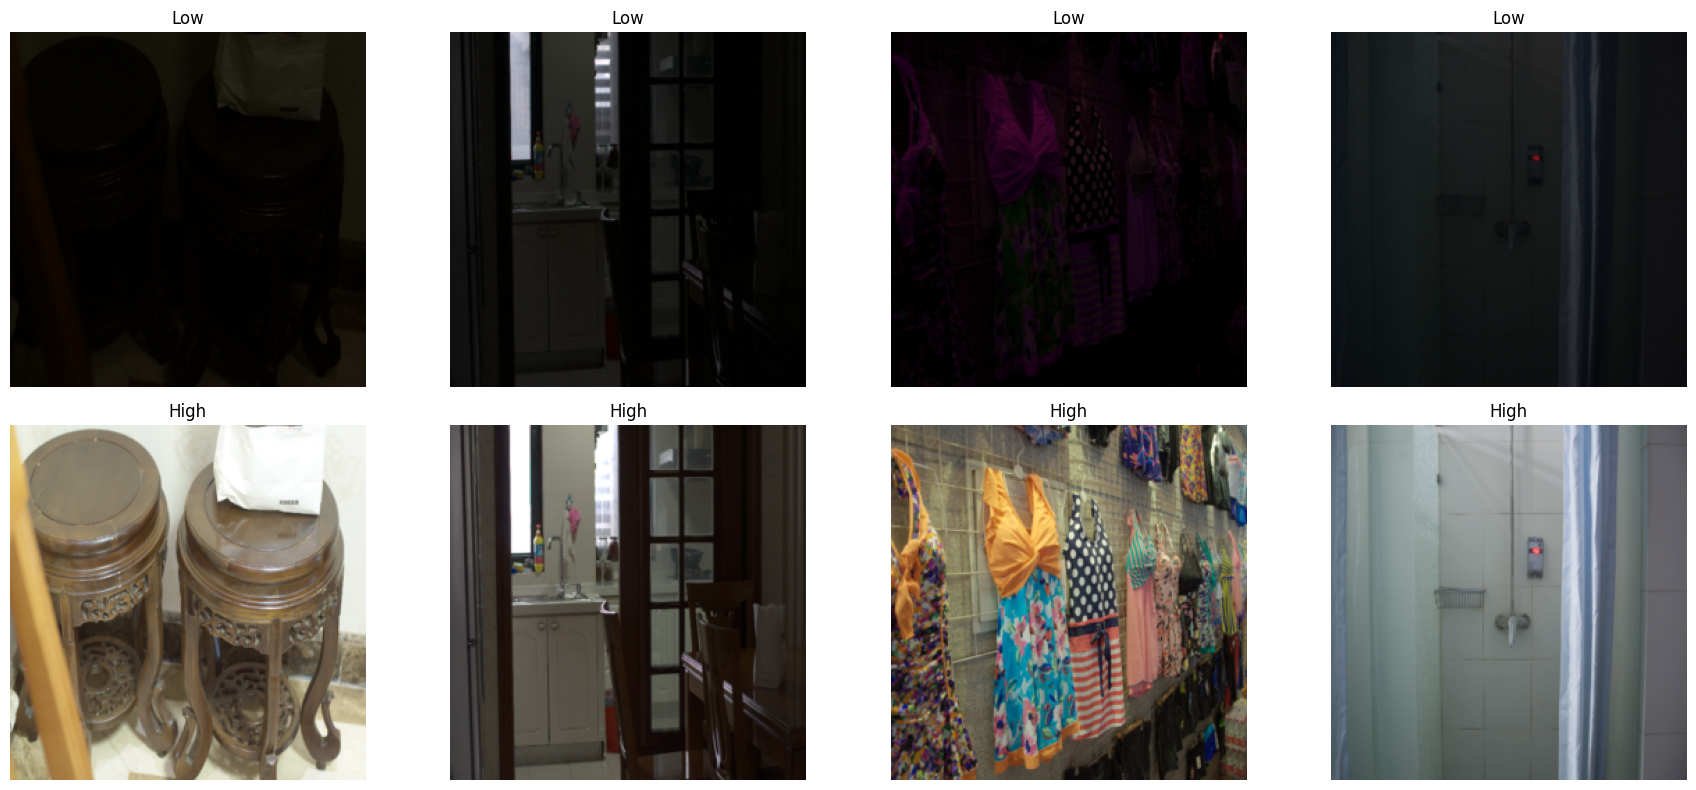

In [6]:
low, high, low_filename, high_filename = next(iter(train_loader))
print("Low resolution file name:", low_filename)
print("High resolution file name:", high_filename)
show_true_images(low, high)

## Model Architecture

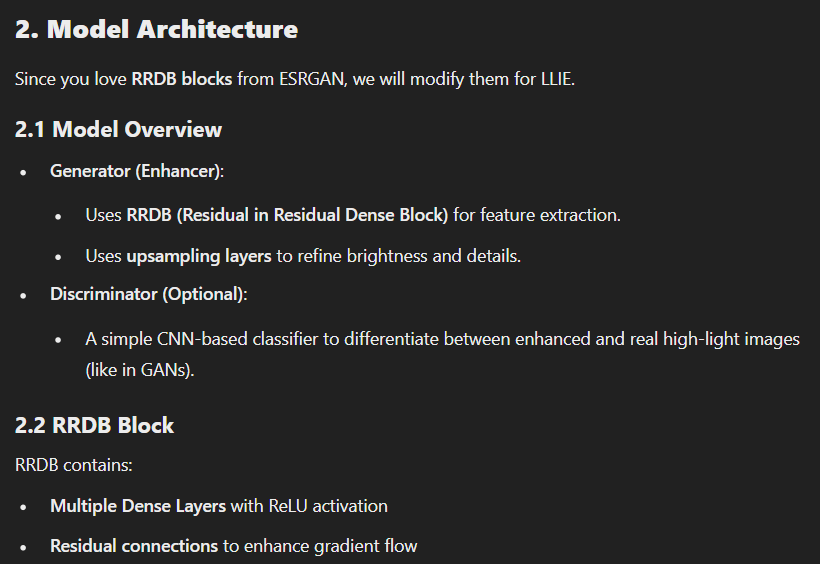

In [7]:
## RRDB blocks architecture derived from the paper ESRGAN..

class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels=64, growth_rate=32):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels + growth_rate, growth_rate, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels + 2 * growth_rate, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out1 = torch.relu(self.conv1(x))
        out2 = torch.relu(self.conv2(torch.cat([x, out1], dim=1)))
        out3 = self.conv3(torch.cat([x, out1, out2], dim=1))
        return x + out3

class RRDB(nn.Module):
    def __init__(self, in_channels=64, beta=0.2):  
        super(RRDB, self).__init__()
        self.rdb1 = ResidualDenseBlock(in_channels)
        self.rdb2 = ResidualDenseBlock(in_channels)
        self.rdb3 = ResidualDenseBlock(in_channels)
        self.beta = beta  # Scaling factor for residual

    def forward(self, x):
        residual = self.rdb3(self.rdb2(self.rdb1(x)))
        return x + self.beta * residual  # Scaled residual for stability

In [8]:
class Generator(nn.Module):
    def __init__(self, num_rrdb=6):
        super(Generator, self).__init__()

        # Initial feature extraction
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # RRDB Blocks
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in range(num_rrdb)])

        # Global Residual Path (helps learn overall brightness correction)
        self.global_residual = nn.Conv2d(3, 3, kernel_size=3, padding=1)

        # Final convolution layers for reconstruction
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        initial_features = self.initial_conv(x)
        enhanced_features = self.rrdb_blocks(initial_features)
        reconstructed = self.final_conv(enhanced_features)
        
        # Adding the global residual path
        output = reconstructed + self.global_residual(x)
        
        return torch.sigmoid(output)  # Normalize output to [0,1]

In [9]:
'''  Use a Discriminator (GAN Approach)
        This makes the enhanced image look more realistic by forcing the Generator to fool a Discriminator.
        USES PatchGANDiscriminator idea as the Discriminator'''

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3, num_filters=64, num_layers=3):
        super(PatchGANDiscriminator, self).__init__()
        
        # Initial convolutional layer
        layers = [
            nn.Conv2d(in_channels, num_filters, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Intermediate convolutional layers
        for i in range(1, num_layers):
            layers += [
                nn.Conv2d(num_filters * (2 ** (i - 1)), num_filters * (2 ** i), kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(num_filters * (2 ** i)),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        
        # Final convolutional layer
        layers += [
            nn.Conv2d(num_filters * (2 ** (num_layers - 1)), 1, kernel_size=4, stride=1, padding=1)
        ]
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # Output shape: [batch_size, 1, H, W]

In [10]:
## Loss Functions

# L1 Loss (Pixel-Level Difference)
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
        return self.loss(pred, target)

# Perceptual Loss using VGG-19 Features
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:16]  # Use first few layers
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG model
        self.vgg = vgg.eval()
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x_features = self.vgg(x)
        y_features = self.vgg(y)
        return self.criterion(x_features, y_features)

In [11]:
## Common evaluating Metrics
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

# Initialize metrics
psnr = PSNR().to(device)
ssim = SSIM().to(device)
lpips = LPIPS(replace_pooling=True).to(device)

# Initialize models and losses
generator = Generator().to(device)
discriminator = PatchGANDiscriminator().to(device)
opt_g = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_d = optim.Adam(discriminator.parameters(), lr = 4e-4, betas=(0.5, 0.999))

# Losses
criterion_gan = GANLoss()
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

/home/tdiykanba2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated

In [12]:
def validate(generator, val_loader, epoch):
    generator.eval()
    val_metrics = {'psnr': 0, 'ssim': 0, 'lpips': 0, 'val_loss': 0}

    with torch.no_grad():
        for low, high, *_ in tqdm(val_loader, desc=f'Validation Epoch {epoch}', leave=False):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Validation loss (L1 + perceptual)
            loss = (10 * F.l1_loss(fake, high) + 0.1 * criterion_perceptual(fake, high)).item()
            
            # Update metrics
            val_metrics['val_loss'] += loss
            val_metrics['psnr'] += psnr(fake, high)
            val_metrics['ssim'] += ssim(fake, high)
            val_metrics['lpips'] += lpips(fake, high)

    for k in val_metrics:
        val_metrics[k] /= len(val_loader)
    return val_metrics

Source: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py

In [13]:
def compute_gradient_penalty(disc, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = disc(interpolates)
    fake = torch.ones_like(d_interpolates)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [14]:
def train_gan(
    generator,
    discriminator,
    train_loader,
    val_loader,
    criterion_gan,
    criterion_l1,
    criterion_perceptual,
    opt_g,
    opt_d,
    epochs,
    device,
    save_dir="RRDB_CHECKPOINTS_color_jitter"
):
    os.makedirs(save_dir, exist_ok=True)
    best_ssim = 0
    best_psnr=0
    best_lpips=100

    for epoch in range(epochs):
        # Training phase
        generator.train()
        discriminator.train()

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for low, high, *_ in train_bar:
            low, high = low.to(device), high.to(device)

            # --- Discriminator Update ---
            opt_d.zero_grad()

            # Real images
            real_pred = discriminator(high)
            real_loss = criterion_gan(real_pred, True)

            # Fake images
            fake = generator(low).detach()
            fake_pred = discriminator(fake)
            fake_loss = criterion_gan(fake_pred, False)
            
            gp = compute_gradient_penalty(discriminator, high.data, fake.data)
            d_loss = (real_loss + fake_loss) / 2+ 10*gp
            d_loss.backward()
            opt_d.step()

            # --- Generator Update ---
            opt_g.zero_grad()
            fake = generator(low)
            g_gan_loss = criterion_gan(discriminator(fake), True)
            g_l1_loss = criterion_l1(fake, high) * 10
            g_perc_loss = criterion_perceptual(fake, high) * 0.1
            g_loss = g_gan_loss + g_l1_loss + g_perc_loss
            g_loss.backward()
            opt_g.step()

            # Update progress bar
            train_bar.set_postfix({
                'D_loss': f'{d_loss.item():.3f}',
                'G_loss': f'{g_loss.item():.3f}',
                'L1': f'{g_l1_loss.item():.3f}'
            })

        # Validation phase
        val_metrics = validate(generator, val_loader, epoch+1)

        # Print metrics
        print(f"\nValidation @ Epoch {epoch+1}:")
        print(f"PSNR: {val_metrics['psnr']:.2f} dB | SSIM: {val_metrics['ssim']:.4f} | LPIPS: {val_metrics['lpips']:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch+1,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'opt_g': opt_g.state_dict(),
            'opt_d': opt_d.state_dict(),
            'metrics': val_metrics
        }, os.path.join(save_dir, f'epoch_{epoch+1}.pth'))

        # Save best model
        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
            print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
                
        if val_metrics['ssim'] > best_ssim:
            best_ssim = val_metrics['ssim']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
            print(f"🔥 New best model (SSIM: {best_ssim:.4f}) saved!")
                    
        if val_metrics['psnr'] > best_psnr:
            best_psnr = val_metrics['psnr']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
            print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")

        if val_metrics['lpips'] < best_lpips:
            best_lpips = val_metrics['lpips']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
            print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")

        # Sample images
        if (epoch+1) % 5 == 0:
            with torch.no_grad():
                fake = generator(low[:3])  # First 3 samples
                save_image(
                    torch.cat([low[:3], fake, high[:3]], 0),
                    os.path.join(save_dir, f'sample_epoch_{epoch+1}.png'),
                    nrow=3,
                    normalize=True
                )


In [15]:
train_gan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_gan=criterion_gan,
    criterion_l1=criterion_l1,
    criterion_perceptual=criterion_perceptual,
    opt_g=opt_g,
    opt_d=opt_d,
    epochs=200,
    device=device
)

Epoch 1/200: 100%|█| 49/49 [00:26<00:00,  1.85it/s, D_loss=145.599, G_loss=1.902
                                                                                


Validation @ Epoch 1:
PSNR: 15.12 dB | SSIM: 0.6193 | LPIPS: 0.4671
🔥 New best model (PSNR: 15.1250 | LPIPS: 0.4671 | SSIM: 0.6193) saved!
🔥 New best model (LPIPS: 0.4671 | SSIM: 0.6193) saved!
🔥 New best model (PSNR: 15.1250 | SSIM: 0.6193) saved!
🔥 New best model (PSNR: 15.1250 | LPIPS: 0.4671) saved!
🔥 New best model (SSIM: 0.6193) saved!
🔥 New best model (PSNR: 15.1250) saved!
🔥 New best model (LPIPS: 0.4671) saved!


Epoch 2/200: 100%|█| 49/49 [00:26<00:00,  1.84it/s, D_loss=13.353, G_loss=2.288,
                                                                                


Validation @ Epoch 2:
PSNR: 14.98 dB | SSIM: 0.6347 | LPIPS: 0.4247
🔥 New best model (LPIPS: 0.4247 | SSIM: 0.6347) saved!
🔥 New best model (SSIM: 0.6347) saved!
🔥 New best model (LPIPS: 0.4247) saved!


Epoch 3/200: 100%|█| 49/49 [00:26<00:00,  1.82it/s, D_loss=9.636, G_loss=2.704, 
                                                                                


Validation @ Epoch 3:
PSNR: 15.01 dB | SSIM: 0.6724 | LPIPS: 0.3869
🔥 New best model (LPIPS: 0.3869 | SSIM: 0.6724) saved!
🔥 New best model (SSIM: 0.6724) saved!
🔥 New best model (LPIPS: 0.3869) saved!


Epoch 4/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=14.955, G_loss=2.545,
                                                                                


Validation @ Epoch 4:
PSNR: 15.19 dB | SSIM: 0.6933 | LPIPS: 0.3753
🔥 New best model (PSNR: 15.1855 | LPIPS: 0.3753 | SSIM: 0.6933) saved!
🔥 New best model (LPIPS: 0.3753 | SSIM: 0.6933) saved!
🔥 New best model (PSNR: 15.1855 | SSIM: 0.6933) saved!
🔥 New best model (PSNR: 15.1855 | LPIPS: 0.3753) saved!
🔥 New best model (SSIM: 0.6933) saved!
🔥 New best model (PSNR: 15.1855) saved!
🔥 New best model (LPIPS: 0.3753) saved!


Epoch 5/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=15.182, G_loss=2.471,
                                                                                


Validation @ Epoch 5:
PSNR: 15.24 dB | SSIM: 0.7086 | LPIPS: 0.3635
🔥 New best model (PSNR: 15.2378 | LPIPS: 0.3635 | SSIM: 0.7086) saved!
🔥 New best model (LPIPS: 0.3635 | SSIM: 0.7086) saved!
🔥 New best model (PSNR: 15.2378 | SSIM: 0.7086) saved!
🔥 New best model (PSNR: 15.2378 | LPIPS: 0.3635) saved!
🔥 New best model (SSIM: 0.7086) saved!
🔥 New best model (PSNR: 15.2378) saved!
🔥 New best model (LPIPS: 0.3635) saved!


Epoch 6/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=3.588, G_loss=2.220, 
                                                                                


Validation @ Epoch 6:
PSNR: 16.25 dB | SSIM: 0.7497 | LPIPS: 0.3228
🔥 New best model (PSNR: 16.2528 | LPIPS: 0.3228 | SSIM: 0.7497) saved!
🔥 New best model (LPIPS: 0.3228 | SSIM: 0.7497) saved!
🔥 New best model (PSNR: 16.2528 | SSIM: 0.7497) saved!
🔥 New best model (PSNR: 16.2528 | LPIPS: 0.3228) saved!
🔥 New best model (SSIM: 0.7497) saved!
🔥 New best model (PSNR: 16.2528) saved!
🔥 New best model (LPIPS: 0.3228) saved!


Epoch 7/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.695, G_loss=1.696, 
                                                                                


Validation @ Epoch 7:
PSNR: 16.54 dB | SSIM: 0.7600 | LPIPS: 0.3376
🔥 New best model (PSNR: 16.5400 | SSIM: 0.7600) saved!
🔥 New best model (SSIM: 0.7600) saved!
🔥 New best model (PSNR: 16.5400) saved!


Epoch 8/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.031, G_loss=1.738, 
                                                                                


Validation @ Epoch 8:
PSNR: 17.01 dB | SSIM: 0.7687 | LPIPS: 0.2960
🔥 New best model (PSNR: 17.0073 | LPIPS: 0.2960 | SSIM: 0.7687) saved!
🔥 New best model (LPIPS: 0.2960 | SSIM: 0.7687) saved!
🔥 New best model (PSNR: 17.0073 | SSIM: 0.7687) saved!
🔥 New best model (PSNR: 17.0073 | LPIPS: 0.2960) saved!
🔥 New best model (SSIM: 0.7687) saved!
🔥 New best model (PSNR: 17.0073) saved!
🔥 New best model (LPIPS: 0.2960) saved!


Epoch 9/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=3.922, G_loss=2.158, 
                                                                                


Validation @ Epoch 9:
PSNR: 16.17 dB | SSIM: 0.7575 | LPIPS: 0.3122


Epoch 10/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.937, G_loss=2.025,
                                                                                


Validation @ Epoch 10:
PSNR: 16.72 dB | SSIM: 0.7719 | LPIPS: 0.3077
🔥 New best model (SSIM: 0.7719) saved!


Epoch 11/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.077, G_loss=2.267,
                                                                                


Validation @ Epoch 11:
PSNR: 15.72 dB | SSIM: 0.7537 | LPIPS: 0.3084


Epoch 12/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.893, G_loss=1.582,
                                                                                


Validation @ Epoch 12:
PSNR: 16.70 dB | SSIM: 0.7737 | LPIPS: 0.2956
🔥 New best model (LPIPS: 0.2956 | SSIM: 0.7737) saved!
🔥 New best model (SSIM: 0.7737) saved!
🔥 New best model (LPIPS: 0.2956) saved!


Epoch 13/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=2.999, G_loss=1.821,
                                                                                


Validation @ Epoch 13:
PSNR: 16.72 dB | SSIM: 0.7822 | LPIPS: 0.2869
🔥 New best model (LPIPS: 0.2869 | SSIM: 0.7822) saved!
🔥 New best model (SSIM: 0.7822) saved!
🔥 New best model (LPIPS: 0.2869) saved!


Epoch 14/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.431, G_loss=1.985,
                                                                                


Validation @ Epoch 14:
PSNR: 16.80 dB | SSIM: 0.7857 | LPIPS: 0.2833
🔥 New best model (LPIPS: 0.2833 | SSIM: 0.7857) saved!
🔥 New best model (SSIM: 0.7857) saved!
🔥 New best model (LPIPS: 0.2833) saved!


Epoch 15/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.417, G_loss=2.318,
                                                                                


Validation @ Epoch 15:
PSNR: 15.04 dB | SSIM: 0.7329 | LPIPS: 0.3093


Epoch 16/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.843, G_loss=2.097,
                                                                                


Validation @ Epoch 16:
PSNR: 16.90 dB | SSIM: 0.7883 | LPIPS: 0.2802
🔥 New best model (LPIPS: 0.2802 | SSIM: 0.7883) saved!
🔥 New best model (SSIM: 0.7883) saved!
🔥 New best model (LPIPS: 0.2802) saved!


Epoch 17/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.972, G_loss=2.248,
                                                                                


Validation @ Epoch 17:
PSNR: 16.82 dB | SSIM: 0.7983 | LPIPS: 0.2660
🔥 New best model (LPIPS: 0.2660 | SSIM: 0.7983) saved!
🔥 New best model (SSIM: 0.7983) saved!
🔥 New best model (LPIPS: 0.2660) saved!


Epoch 18/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.309, G_loss=1.902,
                                                                                


Validation @ Epoch 18:
PSNR: 15.75 dB | SSIM: 0.7771 | LPIPS: 0.2643
🔥 New best model (LPIPS: 0.2643) saved!


Epoch 19/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=2.469, G_loss=1.504,
                                                                                


Validation @ Epoch 19:
PSNR: 16.83 dB | SSIM: 0.7976 | LPIPS: 0.2718


Epoch 20/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.134, G_loss=1.914,
                                                                                


Validation @ Epoch 20:
PSNR: 16.86 dB | SSIM: 0.8012 | LPIPS: 0.2644
🔥 New best model (SSIM: 0.8012) saved!


Epoch 21/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.771, G_loss=1.893,
                                                                                


Validation @ Epoch 21:
PSNR: 17.03 dB | SSIM: 0.7925 | LPIPS: 0.2808
🔥 New best model (PSNR: 17.0294) saved!


Epoch 22/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=2.416, G_loss=2.436,
                                                                                


Validation @ Epoch 22:
PSNR: 16.70 dB | SSIM: 0.7973 | LPIPS: 0.2629
🔥 New best model (LPIPS: 0.2629) saved!


Epoch 23/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.825, G_loss=2.324,
                                                                                


Validation @ Epoch 23:
PSNR: 16.86 dB | SSIM: 0.8065 | LPIPS: 0.2495
🔥 New best model (LPIPS: 0.2495 | SSIM: 0.8065) saved!
🔥 New best model (SSIM: 0.8065) saved!
🔥 New best model (LPIPS: 0.2495) saved!


Epoch 24/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.993, G_loss=1.915,
                                                                                


Validation @ Epoch 24:
PSNR: 17.16 dB | SSIM: 0.8024 | LPIPS: 0.2639
🔥 New best model (PSNR: 17.1579) saved!


Epoch 25/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.762, G_loss=2.303,
                                                                                


Validation @ Epoch 25:
PSNR: 16.69 dB | SSIM: 0.8048 | LPIPS: 0.2615


Epoch 26/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.762, G_loss=2.052,
                                                                                


Validation @ Epoch 26:
PSNR: 16.29 dB | SSIM: 0.7910 | LPIPS: 0.2568


Epoch 27/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.128, G_loss=1.710,
                                                                                


Validation @ Epoch 27:
PSNR: 16.93 dB | SSIM: 0.8106 | LPIPS: 0.2574
🔥 New best model (SSIM: 0.8106) saved!


Epoch 28/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.873, G_loss=2.629,
                                                                                


Validation @ Epoch 28:
PSNR: 16.80 dB | SSIM: 0.8028 | LPIPS: 0.2537


Epoch 29/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.766, G_loss=1.908,
                                                                                


Validation @ Epoch 29:
PSNR: 16.67 dB | SSIM: 0.8045 | LPIPS: 0.2560


Epoch 30/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.762, G_loss=1.521,
                                                                                


Validation @ Epoch 30:
PSNR: 17.12 dB | SSIM: 0.8129 | LPIPS: 0.2490
🔥 New best model (LPIPS: 0.2490 | SSIM: 0.8129) saved!
🔥 New best model (SSIM: 0.8129) saved!
🔥 New best model (LPIPS: 0.2490) saved!


Epoch 31/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.808, G_loss=1.895,
                                                                                


Validation @ Epoch 31:
PSNR: 17.00 dB | SSIM: 0.8125 | LPIPS: 0.2401
🔥 New best model (LPIPS: 0.2401) saved!


Epoch 32/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.875, G_loss=2.115,
                                                                                


Validation @ Epoch 32:
PSNR: 16.93 dB | SSIM: 0.8144 | LPIPS: 0.2424
🔥 New best model (SSIM: 0.8144) saved!


Epoch 33/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.289, G_loss=1.899,
                                                                                


Validation @ Epoch 33:
PSNR: 16.59 dB | SSIM: 0.8050 | LPIPS: 0.2536


Epoch 34/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.930, G_loss=1.979,
                                                                                


Validation @ Epoch 34:
PSNR: 16.82 dB | SSIM: 0.8084 | LPIPS: 0.2476


Epoch 35/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.815, G_loss=1.982,
                                                                                


Validation @ Epoch 35:
PSNR: 16.84 dB | SSIM: 0.8120 | LPIPS: 0.2504


Epoch 36/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.952, G_loss=1.684,
                                                                                


Validation @ Epoch 36:
PSNR: 16.59 dB | SSIM: 0.7859 | LPIPS: 0.2673


Epoch 37/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.756, G_loss=2.772,
                                                                                


Validation @ Epoch 37:
PSNR: 16.68 dB | SSIM: 0.8139 | LPIPS: 0.2537


Epoch 38/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.912, G_loss=1.908,
                                                                                


Validation @ Epoch 38:
PSNR: 16.97 dB | SSIM: 0.8163 | LPIPS: 0.2374
🔥 New best model (LPIPS: 0.2374 | SSIM: 0.8163) saved!
🔥 New best model (SSIM: 0.8163) saved!
🔥 New best model (LPIPS: 0.2374) saved!


Epoch 39/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.867, G_loss=1.755,
                                                                                


Validation @ Epoch 39:
PSNR: 16.95 dB | SSIM: 0.8138 | LPIPS: 0.2486


Epoch 40/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.910, G_loss=1.835,
                                                                                


Validation @ Epoch 40:
PSNR: 16.93 dB | SSIM: 0.8191 | LPIPS: 0.2518
🔥 New best model (SSIM: 0.8191) saved!


Epoch 41/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.812, G_loss=1.619,
                                                                                


Validation @ Epoch 41:
PSNR: 17.26 dB | SSIM: 0.8252 | LPIPS: 0.2344
🔥 New best model (PSNR: 17.2594 | LPIPS: 0.2344 | SSIM: 0.8252) saved!
🔥 New best model (LPIPS: 0.2344 | SSIM: 0.8252) saved!
🔥 New best model (PSNR: 17.2594 | SSIM: 0.8252) saved!
🔥 New best model (PSNR: 17.2594 | LPIPS: 0.2344) saved!
🔥 New best model (SSIM: 0.8252) saved!
🔥 New best model (PSNR: 17.2594) saved!
🔥 New best model (LPIPS: 0.2344) saved!


Epoch 42/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.716, G_loss=1.848,
                                                                                


Validation @ Epoch 42:
PSNR: 16.58 dB | SSIM: 0.8088 | LPIPS: 0.2558


Epoch 43/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.759, G_loss=1.628,
                                                                                


Validation @ Epoch 43:
PSNR: 17.17 dB | SSIM: 0.8269 | LPIPS: 0.2345
🔥 New best model (SSIM: 0.8269) saved!


Epoch 44/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.779, G_loss=1.754,
                                                                                


Validation @ Epoch 44:
PSNR: 16.97 dB | SSIM: 0.8222 | LPIPS: 0.2336
🔥 New best model (LPIPS: 0.2336) saved!


Epoch 45/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.856, G_loss=2.015,
                                                                                


Validation @ Epoch 45:
PSNR: 16.95 dB | SSIM: 0.8113 | LPIPS: 0.2489


Epoch 46/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.845, G_loss=1.725,
                                                                                


Validation @ Epoch 46:
PSNR: 17.29 dB | SSIM: 0.8275 | LPIPS: 0.2274
🔥 New best model (PSNR: 17.2860 | LPIPS: 0.2274 | SSIM: 0.8275) saved!
🔥 New best model (LPIPS: 0.2274 | SSIM: 0.8275) saved!
🔥 New best model (PSNR: 17.2860 | SSIM: 0.8275) saved!
🔥 New best model (PSNR: 17.2860 | LPIPS: 0.2274) saved!
🔥 New best model (SSIM: 0.8275) saved!
🔥 New best model (PSNR: 17.2860) saved!
🔥 New best model (LPIPS: 0.2274) saved!


Epoch 47/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.520, G_loss=1.769,
                                                                                


Validation @ Epoch 47:
PSNR: 17.01 dB | SSIM: 0.8217 | LPIPS: 0.2399


Epoch 48/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.781, G_loss=2.420,
                                                                                


Validation @ Epoch 48:
PSNR: 17.01 dB | SSIM: 0.8238 | LPIPS: 0.2553


Epoch 49/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.739, G_loss=1.802,
                                                                                


Validation @ Epoch 49:
PSNR: 17.27 dB | SSIM: 0.8286 | LPIPS: 0.2300
🔥 New best model (SSIM: 0.8286) saved!


Epoch 50/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.732, G_loss=1.906,
                                                                                


Validation @ Epoch 50:
PSNR: 17.25 dB | SSIM: 0.8263 | LPIPS: 0.2349


Epoch 51/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.743, G_loss=1.817,
                                                                                


Validation @ Epoch 51:
PSNR: 17.22 dB | SSIM: 0.8257 | LPIPS: 0.2355


Epoch 52/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.715, G_loss=1.555,
                                                                                


Validation @ Epoch 52:
PSNR: 17.31 dB | SSIM: 0.8251 | LPIPS: 0.2446
🔥 New best model (PSNR: 17.3115) saved!


Epoch 53/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.205, G_loss=1.904,
                                                                                


Validation @ Epoch 53:
PSNR: 17.30 dB | SSIM: 0.8272 | LPIPS: 0.2369


Epoch 54/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.913, G_loss=2.520,
                                                                                


Validation @ Epoch 54:
PSNR: 17.17 dB | SSIM: 0.8159 | LPIPS: 0.2374


Epoch 55/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.808, G_loss=1.581,
                                                                                


Validation @ Epoch 55:
PSNR: 16.53 dB | SSIM: 0.7981 | LPIPS: 0.2490


Epoch 56/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.017, G_loss=1.680,
                                                                                


Validation @ Epoch 56:
PSNR: 16.26 dB | SSIM: 0.8069 | LPIPS: 0.2452


Epoch 57/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.721, G_loss=1.713,
                                                                                


Validation @ Epoch 57:
PSNR: 17.25 dB | SSIM: 0.8303 | LPIPS: 0.2276
🔥 New best model (SSIM: 0.8303) saved!


Epoch 58/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.835, G_loss=1.894,
                                                                                


Validation @ Epoch 58:
PSNR: 16.94 dB | SSIM: 0.8250 | LPIPS: 0.2256
🔥 New best model (LPIPS: 0.2256) saved!


Epoch 59/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.764, G_loss=1.912,
                                                                                


Validation @ Epoch 59:
PSNR: 17.49 dB | SSIM: 0.8348 | LPIPS: 0.2216
🔥 New best model (PSNR: 17.4868 | LPIPS: 0.2216 | SSIM: 0.8348) saved!
🔥 New best model (LPIPS: 0.2216 | SSIM: 0.8348) saved!
🔥 New best model (PSNR: 17.4868 | SSIM: 0.8348) saved!
🔥 New best model (PSNR: 17.4868 | LPIPS: 0.2216) saved!
🔥 New best model (SSIM: 0.8348) saved!
🔥 New best model (PSNR: 17.4868) saved!
🔥 New best model (LPIPS: 0.2216) saved!


Epoch 60/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.727, G_loss=1.647,
                                                                                


Validation @ Epoch 60:
PSNR: 17.65 dB | SSIM: 0.8324 | LPIPS: 0.2447
🔥 New best model (PSNR: 17.6548) saved!


Epoch 61/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.816, G_loss=2.457,
                                                                                


Validation @ Epoch 61:
PSNR: 17.29 dB | SSIM: 0.8331 | LPIPS: 0.2314


Epoch 62/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.715, G_loss=2.083,
                                                                                


Validation @ Epoch 62:
PSNR: 17.04 dB | SSIM: 0.8240 | LPIPS: 0.2452


Epoch 63/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.731, G_loss=1.556,
                                                                                


Validation @ Epoch 63:
PSNR: 16.91 dB | SSIM: 0.8259 | LPIPS: 0.2265


Epoch 64/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.752, G_loss=1.904,
                                                                                


Validation @ Epoch 64:
PSNR: 17.38 dB | SSIM: 0.8329 | LPIPS: 0.2290


Epoch 65/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.827, G_loss=1.960,
                                                                                


Validation @ Epoch 65:
PSNR: 17.33 dB | SSIM: 0.8366 | LPIPS: 0.2219
🔥 New best model (SSIM: 0.8366) saved!


Epoch 66/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.851, G_loss=1.571,
                                                                                


Validation @ Epoch 66:
PSNR: 17.65 dB | SSIM: 0.8378 | LPIPS: 0.2286
🔥 New best model (SSIM: 0.8378) saved!


Epoch 67/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.721, G_loss=1.568,
                                                                                


Validation @ Epoch 67:
PSNR: 17.65 dB | SSIM: 0.8389 | LPIPS: 0.2254
🔥 New best model (SSIM: 0.8389) saved!


Epoch 68/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.699, G_loss=1.687,
                                                                                


Validation @ Epoch 68:
PSNR: 17.40 dB | SSIM: 0.8374 | LPIPS: 0.2202
🔥 New best model (LPIPS: 0.2202) saved!


Epoch 69/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.733, G_loss=1.496,
                                                                                


Validation @ Epoch 69:
PSNR: 17.38 dB | SSIM: 0.8351 | LPIPS: 0.2199
🔥 New best model (LPIPS: 0.2199) saved!


Epoch 70/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.842, G_loss=1.733,
                                                                                


Validation @ Epoch 70:
PSNR: 17.19 dB | SSIM: 0.8324 | LPIPS: 0.2334


Epoch 71/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.815, G_loss=1.554,
                                                                                


Validation @ Epoch 71:
PSNR: 17.49 dB | SSIM: 0.8358 | LPIPS: 0.2217


Epoch 72/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.745, G_loss=1.612,
                                                                                


Validation @ Epoch 72:
PSNR: 17.15 dB | SSIM: 0.8296 | LPIPS: 0.2357


Epoch 73/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.698, G_loss=2.054,
                                                                                


Validation @ Epoch 73:
PSNR: 17.54 dB | SSIM: 0.8353 | LPIPS: 0.2242


Epoch 74/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.714, G_loss=1.565,
                                                                                


Validation @ Epoch 74:
PSNR: 17.64 dB | SSIM: 0.8399 | LPIPS: 0.2135
🔥 New best model (LPIPS: 0.2135 | SSIM: 0.8399) saved!
🔥 New best model (SSIM: 0.8399) saved!
🔥 New best model (LPIPS: 0.2135) saved!


Epoch 75/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.948, G_loss=2.001,
                                                                                


Validation @ Epoch 75:
PSNR: 17.16 dB | SSIM: 0.8295 | LPIPS: 0.2336


Epoch 76/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=2.307, G_loss=2.340,
                                                                                


Validation @ Epoch 76:
PSNR: 17.03 dB | SSIM: 0.8257 | LPIPS: 0.2426


Epoch 77/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.711, G_loss=1.800,
                                                                                


Validation @ Epoch 77:
PSNR: 17.88 dB | SSIM: 0.8419 | LPIPS: 0.2183
🔥 New best model (PSNR: 17.8847 | SSIM: 0.8419) saved!
🔥 New best model (SSIM: 0.8419) saved!
🔥 New best model (PSNR: 17.8847) saved!


Epoch 78/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.713, G_loss=2.183,
                                                                                


Validation @ Epoch 78:
PSNR: 17.22 dB | SSIM: 0.8337 | LPIPS: 0.2339


Epoch 79/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.740, G_loss=1.692,
                                                                                


Validation @ Epoch 79:
PSNR: 17.38 dB | SSIM: 0.8342 | LPIPS: 0.2345


Epoch 80/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.720, G_loss=1.402,
                                                                                


Validation @ Epoch 80:
PSNR: 17.21 dB | SSIM: 0.8266 | LPIPS: 0.2347


Epoch 81/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.710, G_loss=1.594,
                                                                                


Validation @ Epoch 81:
PSNR: 17.87 dB | SSIM: 0.8412 | LPIPS: 0.2191


Epoch 82/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.724, G_loss=1.839,
                                                                                


Validation @ Epoch 82:
PSNR: 17.23 dB | SSIM: 0.8235 | LPIPS: 0.2343


Epoch 83/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.707, G_loss=1.941,
                                                                                


Validation @ Epoch 83:
PSNR: 16.81 dB | SSIM: 0.8280 | LPIPS: 0.2399


Epoch 84/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.720, G_loss=2.292,
                                                                                


Validation @ Epoch 84:
PSNR: 17.16 dB | SSIM: 0.8325 | LPIPS: 0.2205


Epoch 85/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.703, G_loss=1.648,
                                                                                


Validation @ Epoch 85:
PSNR: 17.35 dB | SSIM: 0.8378 | LPIPS: 0.2226


Epoch 86/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.716, G_loss=1.672,
                                                                                


Validation @ Epoch 86:
PSNR: 17.46 dB | SSIM: 0.8380 | LPIPS: 0.2207


Epoch 87/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.723, G_loss=1.588,
                                                                                


Validation @ Epoch 87:
PSNR: 16.79 dB | SSIM: 0.8226 | LPIPS: 0.2638


Epoch 88/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.801, G_loss=1.509,
                                                                                


Validation @ Epoch 88:
PSNR: 17.69 dB | SSIM: 0.8447 | LPIPS: 0.2133
🔥 New best model (LPIPS: 0.2133 | SSIM: 0.8447) saved!
🔥 New best model (SSIM: 0.8447) saved!
🔥 New best model (LPIPS: 0.2133) saved!


Epoch 89/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.706, G_loss=1.590,
                                                                                


Validation @ Epoch 89:
PSNR: 17.15 dB | SSIM: 0.8303 | LPIPS: 0.2342


Epoch 90/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.701, G_loss=1.386,
                                                                                


Validation @ Epoch 90:
PSNR: 17.18 dB | SSIM: 0.8296 | LPIPS: 0.2350


Epoch 91/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.723, G_loss=1.755,
                                                                                


Validation @ Epoch 91:
PSNR: 17.13 dB | SSIM: 0.8321 | LPIPS: 0.2366


Epoch 92/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.702, G_loss=1.418,
                                                                                


Validation @ Epoch 92:
PSNR: 17.75 dB | SSIM: 0.8398 | LPIPS: 0.2233


Epoch 93/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.701, G_loss=1.807,
                                                                                


Validation @ Epoch 93:
PSNR: 17.52 dB | SSIM: 0.8400 | LPIPS: 0.2289


Epoch 94/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.697, G_loss=1.747,
                                                                                


Validation @ Epoch 94:
PSNR: 17.16 dB | SSIM: 0.8333 | LPIPS: 0.2219


Epoch 95/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=274.435, G_loss=1.25
                                                                                


Validation @ Epoch 95:
PSNR: 17.88 dB | SSIM: 0.8472 | LPIPS: 0.2127
🔥 New best model (LPIPS: 0.2127 | SSIM: 0.8472) saved!
🔥 New best model (SSIM: 0.8472) saved!
🔥 New best model (LPIPS: 0.2127) saved!


Epoch 96/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=2.217, G_loss=1.800,
                                                                                


Validation @ Epoch 96:
PSNR: 17.53 dB | SSIM: 0.8363 | LPIPS: 0.2616


Epoch 97/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.924, G_loss=1.769,
                                                                                


Validation @ Epoch 97:
PSNR: 17.59 dB | SSIM: 0.8417 | LPIPS: 0.2194


Epoch 98/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.257, G_loss=1.588,
                                                                                


Validation @ Epoch 98:
PSNR: 17.45 dB | SSIM: 0.8305 | LPIPS: 0.2404


Epoch 99/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.300, G_loss=1.595,
                                                                                


Validation @ Epoch 99:
PSNR: 17.68 dB | SSIM: 0.8468 | LPIPS: 0.2130


Epoch 100/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.264, G_loss=1.513
                                                                                


Validation @ Epoch 100:
PSNR: 17.63 dB | SSIM: 0.8436 | LPIPS: 0.2165


Epoch 101/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.356, G_loss=1.798
                                                                                


Validation @ Epoch 101:
PSNR: 17.94 dB | SSIM: 0.8468 | LPIPS: 0.2108
🔥 New best model (PSNR: 17.9359 | LPIPS: 0.2108) saved!
🔥 New best model (PSNR: 17.9359) saved!
🔥 New best model (LPIPS: 0.2108) saved!


Epoch 102/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.468, G_loss=1.770
                                                                                


Validation @ Epoch 102:
PSNR: 17.14 dB | SSIM: 0.8344 | LPIPS: 0.2336


Epoch 103/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.176, G_loss=1.723
                                                                                


Validation @ Epoch 103:
PSNR: 17.51 dB | SSIM: 0.8361 | LPIPS: 0.2181


Epoch 104/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.975, G_loss=1.437
                                                                                


Validation @ Epoch 104:
PSNR: 17.84 dB | SSIM: 0.8459 | LPIPS: 0.2173


Epoch 105/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.385, G_loss=1.396
                                                                                


Validation @ Epoch 105:
PSNR: 17.66 dB | SSIM: 0.8441 | LPIPS: 0.2153


Epoch 106/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.493, G_loss=1.522
                                                                                


Validation @ Epoch 106:
PSNR: 17.76 dB | SSIM: 0.8454 | LPIPS: 0.2209


Epoch 107/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.909, G_loss=1.662
                                                                                


Validation @ Epoch 107:
PSNR: 17.78 dB | SSIM: 0.8443 | LPIPS: 0.2156


Epoch 108/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.251, G_loss=2.129
                                                                                


Validation @ Epoch 108:
PSNR: 17.53 dB | SSIM: 0.8361 | LPIPS: 0.2256


Epoch 109/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.953, G_loss=1.841
                                                                                


Validation @ Epoch 109:
PSNR: 17.29 dB | SSIM: 0.8337 | LPIPS: 0.2195


Epoch 110/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.710, G_loss=1.756
                                                                                


Validation @ Epoch 110:
PSNR: 17.21 dB | SSIM: 0.8291 | LPIPS: 0.2260


Epoch 111/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.992, G_loss=1.347
                                                                                


Validation @ Epoch 111:
PSNR: 17.77 dB | SSIM: 0.8420 | LPIPS: 0.2105
🔥 New best model (LPIPS: 0.2105) saved!


Epoch 112/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.901, G_loss=1.545
                                                                                


Validation @ Epoch 112:
PSNR: 17.65 dB | SSIM: 0.8433 | LPIPS: 0.2195


Epoch 113/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.083, G_loss=1.885
                                                                                


Validation @ Epoch 113:
PSNR: 18.21 dB | SSIM: 0.8486 | LPIPS: 0.2120
🔥 New best model (PSNR: 18.2055 | SSIM: 0.8486) saved!
🔥 New best model (SSIM: 0.8486) saved!
🔥 New best model (PSNR: 18.2055) saved!


Epoch 114/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.796, G_loss=1.586
                                                                                


Validation @ Epoch 114:
PSNR: 17.54 dB | SSIM: 0.8385 | LPIPS: 0.2188


Epoch 115/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.025, G_loss=1.827
                                                                                


Validation @ Epoch 115:
PSNR: 17.48 dB | SSIM: 0.8338 | LPIPS: 0.2187


Epoch 116/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.847, G_loss=1.431
                                                                                


Validation @ Epoch 116:
PSNR: 17.61 dB | SSIM: 0.8402 | LPIPS: 0.2215


Epoch 117/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.986, G_loss=1.798
                                                                                


Validation @ Epoch 117:
PSNR: 17.23 dB | SSIM: 0.8243 | LPIPS: 0.2372


Epoch 118/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.848, G_loss=1.753
                                                                                


Validation @ Epoch 118:
PSNR: 17.91 dB | SSIM: 0.8463 | LPIPS: 0.2244


Epoch 119/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.791, G_loss=1.476
                                                                                


Validation @ Epoch 119:
PSNR: 17.62 dB | SSIM: 0.8413 | LPIPS: 0.2215


Epoch 120/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.127, G_loss=1.858
                                                                                


Validation @ Epoch 120:
PSNR: 17.38 dB | SSIM: 0.8404 | LPIPS: 0.2180


Epoch 121/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.770, G_loss=1.581
                                                                                


Validation @ Epoch 121:
PSNR: 17.89 dB | SSIM: 0.8438 | LPIPS: 0.2166


Epoch 122/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.769, G_loss=1.856
                                                                                


Validation @ Epoch 122:
PSNR: 17.49 dB | SSIM: 0.8415 | LPIPS: 0.2191


Epoch 123/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.811, G_loss=1.479
                                                                                


Validation @ Epoch 123:
PSNR: 17.82 dB | SSIM: 0.8412 | LPIPS: 0.2258


Epoch 124/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.824, G_loss=1.588
                                                                                


Validation @ Epoch 124:
PSNR: 17.63 dB | SSIM: 0.8368 | LPIPS: 0.2278


Epoch 125/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.859, G_loss=1.948
                                                                                


Validation @ Epoch 125:
PSNR: 17.42 dB | SSIM: 0.8385 | LPIPS: 0.2261


Epoch 126/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.921, G_loss=1.757
                                                                                


Validation @ Epoch 126:
PSNR: 17.56 dB | SSIM: 0.8413 | LPIPS: 0.2271


Epoch 127/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.743, G_loss=1.279
                                                                                


Validation @ Epoch 127:
PSNR: 17.94 dB | SSIM: 0.8475 | LPIPS: 0.2195


Epoch 128/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.838, G_loss=1.793
                                                                                


Validation @ Epoch 128:
PSNR: 17.89 dB | SSIM: 0.8396 | LPIPS: 0.2206


Epoch 129/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.825, G_loss=1.597
                                                                                


Validation @ Epoch 129:
PSNR: 17.13 dB | SSIM: 0.8357 | LPIPS: 0.2302


Epoch 130/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.947, G_loss=1.510
                                                                                


Validation @ Epoch 130:
PSNR: 17.91 dB | SSIM: 0.8452 | LPIPS: 0.2140


Epoch 131/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.975, G_loss=1.934
                                                                                


Validation @ Epoch 131:
PSNR: 17.58 dB | SSIM: 0.8413 | LPIPS: 0.2131


Epoch 132/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.019, G_loss=1.687
                                                                                


Validation @ Epoch 132:
PSNR: 17.91 dB | SSIM: 0.8442 | LPIPS: 0.2212


Epoch 133/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.744, G_loss=1.677
                                                                                


Validation @ Epoch 133:
PSNR: 17.71 dB | SSIM: 0.8469 | LPIPS: 0.2151


Epoch 134/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.719, G_loss=1.330
                                                                                


Validation @ Epoch 134:
PSNR: 17.66 dB | SSIM: 0.8389 | LPIPS: 0.2288


Epoch 135/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.788, G_loss=1.994
                                                                                


Validation @ Epoch 135:
PSNR: 17.43 dB | SSIM: 0.8346 | LPIPS: 0.2241


Epoch 136/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.876, G_loss=1.590
                                                                                


Validation @ Epoch 136:
PSNR: 17.75 dB | SSIM: 0.8414 | LPIPS: 0.2280


Epoch 137/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.812, G_loss=1.437
                                                                                


Validation @ Epoch 137:
PSNR: 18.07 dB | SSIM: 0.8504 | LPIPS: 0.2158
🔥 New best model (SSIM: 0.8504) saved!


Epoch 138/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.919, G_loss=1.898
                                                                                


Validation @ Epoch 138:
PSNR: 17.87 dB | SSIM: 0.8421 | LPIPS: 0.2150


Epoch 139/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=2.238, G_loss=1.520
                                                                                


Validation @ Epoch 139:
PSNR: 18.12 dB | SSIM: 0.8488 | LPIPS: 0.2201


Epoch 140/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=2052.450, G_loss=2.
                                                                                


Validation @ Epoch 140:
PSNR: 17.50 dB | SSIM: 0.8373 | LPIPS: 0.2204


Epoch 141/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.451, G_loss=1.697
                                                                                


Validation @ Epoch 141:
PSNR: 17.50 dB | SSIM: 0.8355 | LPIPS: 0.2218


Epoch 142/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.049, G_loss=1.625
                                                                                


Validation @ Epoch 142:
PSNR: 17.92 dB | SSIM: 0.8450 | LPIPS: 0.2156


Epoch 143/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.754, G_loss=1.730
                                                                                


Validation @ Epoch 143:
PSNR: 17.24 dB | SSIM: 0.8359 | LPIPS: 0.2128


Epoch 144/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.463, G_loss=2.112
                                                                                


Validation @ Epoch 144:
PSNR: 18.01 dB | SSIM: 0.8462 | LPIPS: 0.2152


Epoch 145/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.444, G_loss=1.457
                                                                                


Validation @ Epoch 145:
PSNR: 17.61 dB | SSIM: 0.8399 | LPIPS: 0.2282


Epoch 146/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.088, G_loss=1.698
                                                                                


Validation @ Epoch 146:
PSNR: 17.80 dB | SSIM: 0.8377 | LPIPS: 0.2289


Epoch 147/200: 100%|█| 49/49 [00:27<00:00,  1.75it/s, D_loss=1.051, G_loss=1.438
                                                                                


Validation @ Epoch 147:
PSNR: 17.57 dB | SSIM: 0.8348 | LPIPS: 0.2371


Epoch 148/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.013, G_loss=1.530
                                                                                


Validation @ Epoch 148:
PSNR: 17.94 dB | SSIM: 0.8410 | LPIPS: 0.2255


Epoch 149/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.852, G_loss=1.533
                                                                                


Validation @ Epoch 149:
PSNR: 17.40 dB | SSIM: 0.8316 | LPIPS: 0.2243


Epoch 150/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.206, G_loss=1.716
                                                                                


Validation @ Epoch 150:
PSNR: 17.80 dB | SSIM: 0.8401 | LPIPS: 0.2167


Epoch 151/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.681, G_loss=1.734
                                                                                


Validation @ Epoch 151:
PSNR: 16.82 dB | SSIM: 0.8247 | LPIPS: 0.2350


Epoch 152/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.164, G_loss=1.654
                                                                                


Validation @ Epoch 152:
PSNR: 17.97 dB | SSIM: 0.8446 | LPIPS: 0.2215


Epoch 153/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.092, G_loss=1.852
                                                                                


Validation @ Epoch 153:
PSNR: 17.97 dB | SSIM: 0.8414 | LPIPS: 0.2177


Epoch 154/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.855, G_loss=1.911
                                                                                


Validation @ Epoch 154:
PSNR: 17.63 dB | SSIM: 0.8390 | LPIPS: 0.2206


Epoch 155/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.623, G_loss=2.096
                                                                                


Validation @ Epoch 155:
PSNR: 17.38 dB | SSIM: 0.8354 | LPIPS: 0.2297


Epoch 156/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.961, G_loss=1.934
                                                                                


Validation @ Epoch 156:
PSNR: 17.52 dB | SSIM: 0.8311 | LPIPS: 0.2330


Epoch 157/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.203, G_loss=1.722
                                                                                


Validation @ Epoch 157:
PSNR: 18.23 dB | SSIM: 0.8496 | LPIPS: 0.2087
🔥 New best model (PSNR: 18.2340 | LPIPS: 0.2087) saved!
🔥 New best model (PSNR: 18.2340) saved!
🔥 New best model (LPIPS: 0.2087) saved!


Epoch 158/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.780, G_loss=1.370
                                                                                


Validation @ Epoch 158:
PSNR: 18.03 dB | SSIM: 0.8440 | LPIPS: 0.2174


Epoch 159/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.927, G_loss=1.445
                                                                                


Validation @ Epoch 159:
PSNR: 18.10 dB | SSIM: 0.8505 | LPIPS: 0.2095
🔥 New best model (SSIM: 0.8505) saved!


Epoch 160/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.761, G_loss=1.388
                                                                                


Validation @ Epoch 160:
PSNR: 18.00 dB | SSIM: 0.8425 | LPIPS: 0.2167


Epoch 161/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=4.200, G_loss=1.675
                                                                                


Validation @ Epoch 161:
PSNR: 17.75 dB | SSIM: 0.8410 | LPIPS: 0.2250


Epoch 162/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.017, G_loss=1.388
                                                                                


Validation @ Epoch 162:
PSNR: 16.96 dB | SSIM: 0.8255 | LPIPS: 0.2309


Epoch 163/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.200, G_loss=1.380
                                                                                


Validation @ Epoch 163:
PSNR: 17.89 dB | SSIM: 0.8423 | LPIPS: 0.2254


Epoch 164/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.151, G_loss=1.623
                                                                                


Validation @ Epoch 164:
PSNR: 17.37 dB | SSIM: 0.8293 | LPIPS: 0.2324


Epoch 165/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.851, G_loss=1.681
                                                                                


Validation @ Epoch 165:
PSNR: 17.63 dB | SSIM: 0.8368 | LPIPS: 0.2274


Epoch 166/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.833, G_loss=1.515
                                                                                


Validation @ Epoch 166:
PSNR: 17.98 dB | SSIM: 0.8440 | LPIPS: 0.2215


Epoch 167/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.747, G_loss=1.871
                                                                                


Validation @ Epoch 167:
PSNR: 18.20 dB | SSIM: 0.8411 | LPIPS: 0.2194


Epoch 168/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.161, G_loss=1.359
                                                                                


Validation @ Epoch 168:
PSNR: 17.87 dB | SSIM: 0.8397 | LPIPS: 0.2221


Epoch 169/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.042, G_loss=1.374
                                                                                


Validation @ Epoch 169:
PSNR: 17.62 dB | SSIM: 0.8360 | LPIPS: 0.2238


Epoch 170/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.786, G_loss=1.479
                                                                                


Validation @ Epoch 170:
PSNR: 18.07 dB | SSIM: 0.8469 | LPIPS: 0.2146


Epoch 171/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.813, G_loss=1.749
                                                                                


Validation @ Epoch 171:
PSNR: 18.29 dB | SSIM: 0.8531 | LPIPS: 0.2070
🔥 New best model (PSNR: 18.2879 | LPIPS: 0.2070 | SSIM: 0.8531) saved!
🔥 New best model (LPIPS: 0.2070 | SSIM: 0.8531) saved!
🔥 New best model (PSNR: 18.2879 | SSIM: 0.8531) saved!
🔥 New best model (PSNR: 18.2879 | LPIPS: 0.2070) saved!
🔥 New best model (SSIM: 0.8531) saved!
🔥 New best model (PSNR: 18.2879) saved!
🔥 New best model (LPIPS: 0.2070) saved!


Epoch 172/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.865, G_loss=1.684
                                                                                


Validation @ Epoch 172:
PSNR: 18.01 dB | SSIM: 0.8425 | LPIPS: 0.2264


Epoch 173/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.963, G_loss=1.671
                                                                                


Validation @ Epoch 173:
PSNR: 17.70 dB | SSIM: 0.8368 | LPIPS: 0.2336


Epoch 174/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.734, G_loss=1.522
                                                                                


Validation @ Epoch 174:
PSNR: 17.53 dB | SSIM: 0.8305 | LPIPS: 0.2365


Epoch 175/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.167, G_loss=1.791
                                                                                


Validation @ Epoch 175:
PSNR: 18.15 dB | SSIM: 0.8472 | LPIPS: 0.2207


Epoch 176/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=70.238, G_loss=1.62
                                                                                


Validation @ Epoch 176:
PSNR: 17.93 dB | SSIM: 0.8367 | LPIPS: 0.2285


Epoch 177/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.449, G_loss=1.892
                                                                                


Validation @ Epoch 177:
PSNR: 17.60 dB | SSIM: 0.8355 | LPIPS: 0.2255


Epoch 178/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.128, G_loss=1.517
                                                                                


Validation @ Epoch 178:
PSNR: 17.72 dB | SSIM: 0.8359 | LPIPS: 0.2293


Epoch 179/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.932, G_loss=1.915
                                                                                


Validation @ Epoch 179:
PSNR: 17.69 dB | SSIM: 0.8285 | LPIPS: 0.2333


Epoch 180/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.908, G_loss=1.444
                                                                                


Validation @ Epoch 180:
PSNR: 17.89 dB | SSIM: 0.8413 | LPIPS: 0.2252


Epoch 181/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.856, G_loss=1.448
                                                                                


Validation @ Epoch 181:
PSNR: 17.98 dB | SSIM: 0.8431 | LPIPS: 0.2135


Epoch 182/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.740, G_loss=1.562
                                                                                


Validation @ Epoch 182:
PSNR: 17.89 dB | SSIM: 0.8432 | LPIPS: 0.2217


Epoch 183/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.832, G_loss=1.437
                                                                                


Validation @ Epoch 183:
PSNR: 17.80 dB | SSIM: 0.8349 | LPIPS: 0.2237


Epoch 184/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.842, G_loss=1.452
                                                                                


Validation @ Epoch 184:
PSNR: 17.46 dB | SSIM: 0.8277 | LPIPS: 0.2377


Epoch 185/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.738, G_loss=1.425
                                                                                


Validation @ Epoch 185:
PSNR: 17.79 dB | SSIM: 0.8340 | LPIPS: 0.2278


Epoch 186/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.724, G_loss=1.629
                                                                                


Validation @ Epoch 186:
PSNR: 16.83 dB | SSIM: 0.8125 | LPIPS: 0.2474


Epoch 187/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.593, G_loss=1.577
                                                                                


Validation @ Epoch 187:
PSNR: 17.98 dB | SSIM: 0.8392 | LPIPS: 0.2194


Epoch 188/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.785, G_loss=1.876
                                                                                


Validation @ Epoch 188:
PSNR: 17.87 dB | SSIM: 0.8406 | LPIPS: 0.2196


Epoch 189/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.834, G_loss=1.403
                                                                                


Validation @ Epoch 189:
PSNR: 17.95 dB | SSIM: 0.8448 | LPIPS: 0.2086


Epoch 190/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.721, G_loss=1.752
                                                                                


Validation @ Epoch 190:
PSNR: 17.94 dB | SSIM: 0.8383 | LPIPS: 0.2278


Epoch 191/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.753, G_loss=1.439
                                                                                


Validation @ Epoch 191:
PSNR: 17.46 dB | SSIM: 0.8299 | LPIPS: 0.2363


Epoch 192/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.710, G_loss=1.542
                                                                                


Validation @ Epoch 192:
PSNR: 18.03 dB | SSIM: 0.8391 | LPIPS: 0.2202


Epoch 193/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.860, G_loss=1.545
                                                                                


Validation @ Epoch 193:
PSNR: 18.23 dB | SSIM: 0.8453 | LPIPS: 0.2185


Epoch 194/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.731, G_loss=1.374
                                                                                


Validation @ Epoch 194:
PSNR: 17.96 dB | SSIM: 0.8391 | LPIPS: 0.2260


Epoch 195/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.735, G_loss=1.497
                                                                                


Validation @ Epoch 195:
PSNR: 17.58 dB | SSIM: 0.8340 | LPIPS: 0.2155


Epoch 196/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.914, G_loss=1.882
                                                                                


Validation @ Epoch 196:
PSNR: 17.45 dB | SSIM: 0.8277 | LPIPS: 0.2301


Epoch 197/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.703, G_loss=1.527
                                                                                


Validation @ Epoch 197:
PSNR: 17.21 dB | SSIM: 0.8190 | LPIPS: 0.2402


Epoch 198/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.709, G_loss=1.441
                                                                                


Validation @ Epoch 198:
PSNR: 18.10 dB | SSIM: 0.8428 | LPIPS: 0.2238


Epoch 199/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.731, G_loss=1.545
                                                                                


Validation @ Epoch 199:
PSNR: 18.03 dB | SSIM: 0.8350 | LPIPS: 0.2280


Epoch 200/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.784, G_loss=1.538
                                                                                


Validation @ Epoch 200:
PSNR: 17.99 dB | SSIM: 0.8449 | LPIPS: 0.2223


## Testing Code

In [16]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import os


def add_labels_to_image(image_tensor, labels):
    """
    Add text labels to an image tensor
    Args:
        image_tensor: Tensor of shape (C, H, W)
        labels: List of strings for each section
    Returns:
        Labeled PIL Image
    """
    # Convert tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor.cpu())

    # Create drawing context
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    # Calculate section widths
    width = image.width
    section_width = width // len(labels)

    # Add labels to each section
    for i, label in enumerate(labels):
        # Get text bounding box (modern Pillow)
        left, top, right, bottom = draw.textbbox((0, 0), label, font=font)
        text_width = right - left
        text_height = bottom - top

        x = i * section_width + (section_width - text_width) // 2
        draw.text((x, 10), label, font=font, fill="white")

    return image

In [17]:
def evaluate_model(generator, test_loader, device, save_samples=True, sample_dir="RRDB_CHECKPOINTS_color_jitter/test_samples"):
    # Initialize metrics
    psnr = PSNR().to(device)
    ssim = SSIM().to(device)
    lpips = LPIPS(replace_pooling=True).to(device)

    metrics = {
        'psnr': 0.0,
        'ssim': 0.0,
        'lpips': 0.0,
        'samples': []
    }

    if save_samples:
        os.makedirs(sample_dir, exist_ok=True)

    generator.eval()
    sample_counter = 0
    with torch.no_grad():
        for i, (low, high, *_) in enumerate(tqdm(test_loader, desc="Testing")):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            metrics['psnr'] += psnr(fake, high) * low.size(0)
            metrics['ssim'] += ssim(fake, high) * low.size(0)
            metrics['lpips'] += lpips(fake, high) * low.size(0)

            # Save ALL samples with labels
            if save_samples:
                for img_idx in range(low.size(0)):
                    # Create horizontal comparison
                    comparison = torch.cat([
                        low[img_idx],
                        fake[img_idx],
                        high[img_idx]
                    ], dim=-1)

                    # Convert to labeled image
                    labeled_img = add_labels_to_image(
                        comparison,
                        ["Low Light Input", "Generated Output", "Ground Truth"]
                    )

                    # Save image
                    sample_path = os.path.join(sample_dir, f"sample_{sample_counter:02d}.png")
                    labeled_img.save(sample_path)
                    metrics['samples'].append(sample_path)
                    sample_counter += 1

                    if sample_counter >= 15:
                        break

    # Calculate average metrics
    total_samples = min(15, len(test_loader.dataset))
    metrics['psnr'] /= total_samples
    metrics['ssim'] /= total_samples
    metrics['lpips'] /= total_samples

    return metrics

In [18]:
# 1. Best models 

generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_color_jitter/best_model.pth"))

# Running evaluation
test_metrics = evaluate_model(
        generator=generator,
        test_loader=test_loader,  # Your prepared test loader
        device=device,
        save_samples=True,
    )

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.68it/s]


{'psnr': tensor(18.6033, device='cuda:2'),
 'ssim': tensor(0.8223, device='cuda:2'),
 'lpips': tensor(0.2179, device='cuda:2'),
 'samples': ['RRDB_CHECKPOINTS_color_jitter/test_samples/sample_00.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_01.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_02.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_03.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_04.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_05.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_06.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_07.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_08.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_09.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_10.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_11.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_12.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples/sample_13

In [19]:
# 2. Loading checkpoints with highest PSNR & SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_color_jitter/best_psnr_ssim.pth"))
# checkpoint = torch.load("RRDB_SE_CHECKPOINTS/best_psnr.pth")
# generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.67it/s]


{'psnr': tensor(18.6033, device='cuda:2'),
 'ssim': tensor(0.8223, device='cuda:2'),
 'lpips': tensor(0.2179, device='cuda:2'),
 'samples': ['RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_00.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_01.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_02.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_03.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_04.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_05.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_06.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_07.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_08.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_09.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_10.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_11.png

In [20]:
# 3. Loading checkpoints with highest PSNR & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_color_jitter/best_psnr_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.77it/s]


{'psnr': tensor(18.6033, device='cuda:2'),
 'ssim': tensor(0.8223, device='cuda:2'),
 'lpips': tensor(0.2179, device='cuda:2'),
 'samples': ['RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_00.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_01.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_02.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_03.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_04.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_05.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_06.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_07.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_08.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_09.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_10.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/s

In [21]:
# 4. Loading checkpoints with highest SSIM & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_color_jitter/best_lpips_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.66it/s]


{'psnr': tensor(18.6033, device='cuda:2'),
 'ssim': tensor(0.8223, device='cuda:2'),
 'lpips': tensor(0.2179, device='cuda:2'),
 'samples': ['RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_00.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_01.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_02.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_03.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_04.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_05.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_06.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_07.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_08.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_09.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_10.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/s

In [22]:
# 5. Loading checkpoints with highest PSNR value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_color_jitter/best_psnr.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.69it/s]


{'psnr': tensor(18.6033, device='cuda:2'),
 'ssim': tensor(0.8223, device='cuda:2'),
 'lpips': tensor(0.2179, device='cuda:2'),
 'samples': ['RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_00.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_01.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_02.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_03.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_04.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_05.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_06.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_07.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_08.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_09.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_10.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_11.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_PSNR/sample

In [23]:
# 6. Loading checkpoints with highest SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_color_jitter/best_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.67it/s]


{'psnr': tensor(18.6033, device='cuda:2'),
 'ssim': tensor(0.8223, device='cuda:2'),
 'lpips': tensor(0.2179, device='cuda:2'),
 'samples': ['RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_00.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_01.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_02.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_03.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_04.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_05.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_06.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_07.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_08.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_09.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_10.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_11.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_SSIM/sample

In [24]:
# 7. Loading checkpoints with highest LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_color_jitter/best_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.76it/s]


{'psnr': tensor(18.6033, device='cuda:2'),
 'ssim': tensor(0.8223, device='cuda:2'),
 'lpips': tensor(0.2179, device='cuda:2'),
 'samples': ['RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_00.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_01.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_02.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_03.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_04.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_05.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_06.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_07.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_08.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_09.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_10.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_11.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples

In [25]:
# 8. Loading epoch 200
generator = Generator().to(device)
checkpoint = torch.load("RRDB_CHECKPOINTS_color_jitter/epoch_200.pth")
generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.57it/s]


{'psnr': tensor(18.9734, device='cuda:2'),
 'ssim': tensor(0.8217, device='cuda:2'),
 'lpips': tensor(0.2226, device='cuda:2'),
 'samples': ['RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_00.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_01.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_02.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_03.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_04.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_05.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_06.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_07.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_08.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_09.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_10.png',
  'RRDB_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_11.png',
  'RRDB_C

In [26]:

# Collect all checkpoint files
checkpoint_dir = "RRDB_CHECKPOINTS_color_jitter"
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')],
                         key=lambda x: int(x.split('_')[1].split('.')[0]))

# Initialize lists to store metrics
val_psnr = []
val_ssim = []
val_lpips = []
epochs = []

# Extract metrics from each checkpoint
for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_file), map_location='cpu')  # Load to CPU

    epochs.append(checkpoint['epoch'])

    # Convert metrics to CPU numpy arrays
    val_psnr.append(checkpoint['metrics']['psnr'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['psnr']) else checkpoint['metrics']['psnr'])
    val_ssim.append(checkpoint['metrics']['ssim'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['ssim']) else checkpoint['metrics']['ssim'])
    val_lpips.append(checkpoint['metrics']['lpips'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['lpips']) else checkpoint['metrics']['lpips'])

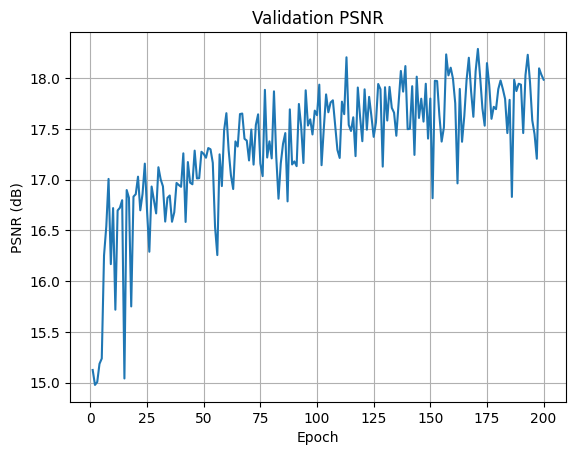

In [27]:
# Validation PSNR
plt.plot(epochs, val_psnr)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)
plt.savefig('RRDB_CHECKPOINTS_color_jitter/validation_psnr.png', dpi=300, bbox_inches='tight')

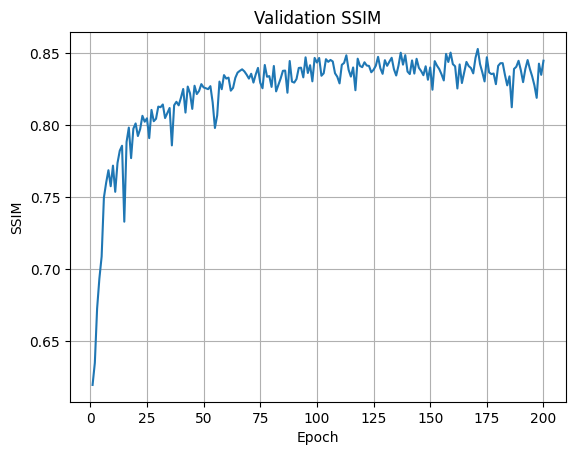

In [28]:
# Validation SSIM

plt.plot(epochs, val_ssim)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.grid(True)
plt.savefig('RRDB_CHECKPOINTS_color_jitter/validation_ssim.png', dpi=300, bbox_inches='tight')

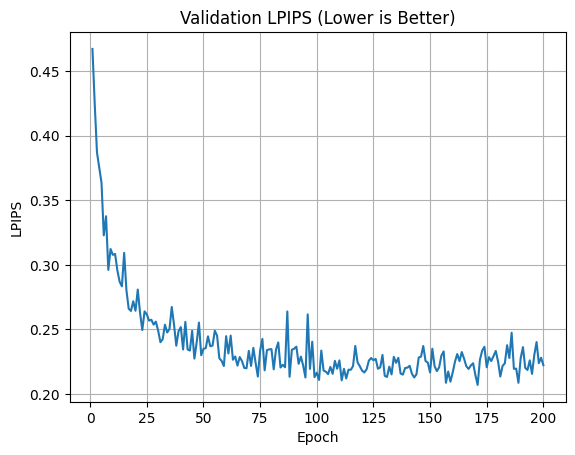

In [29]:
# Validation LPIPS
plt.plot(epochs, val_lpips)
plt.xlabel('Epoch')
plt.ylabel('LPIPS')
plt.title('Validation LPIPS (Lower is Better)')
plt.grid(True)
plt.savefig('RRDB_CHECKPOINTS_color_jitter/validation_lpips.png', dpi=300, bbox_inches='tight')

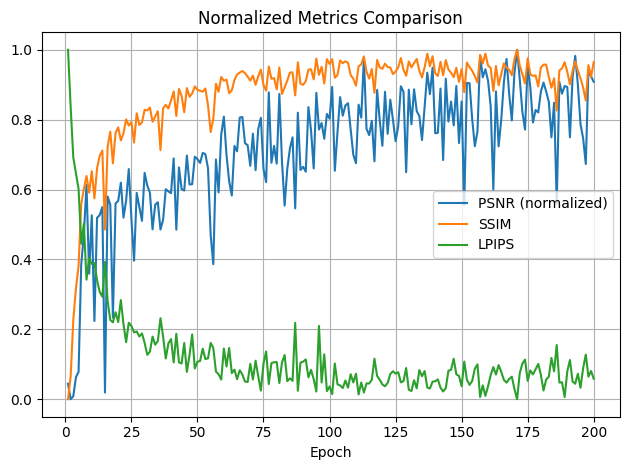

In [30]:
# Combined Metrics
val_psnr_norm = (np.array(val_psnr)-np.min(val_psnr))/(np.max(val_psnr)-np.min(val_psnr))
val_ssim_norm = (np.array(val_ssim)-np.min(val_ssim))/(np.max(val_ssim)-np.min(val_ssim))
val_lpips_norm = (np.array(val_lpips)-np.min(val_lpips))/(np.max(val_lpips)-np.min(val_lpips))

plt.plot(epochs, val_psnr_norm, label='PSNR (normalized)')
plt.plot(epochs, val_ssim_norm, label='SSIM')
plt.plot(epochs, val_lpips_norm, label='LPIPS')
plt.xlabel('Epoch')
plt.title('Normalized Metrics Comparison')
plt.legend(loc='right')
plt.grid(True)

plt.tight_layout()
plt.savefig('RRDB_CHECKPOINTS_color_jitter/training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()